## Random tests for coef

In [1]:
import argparse
import yaml
import numpy as np
import pickle as pkl
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime
import json
import hashlib
import os
import matplotlib.pyplot as plt

from algorithms import BMP
from data_generation import GaussianDataGenerator

In [2]:
p = 600
n = 300
m = 20
noise_level = 0.2

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, random_seed=1)
_ = Data_Geneartor.shuffle()

In [27]:
(
    test_true_signal,
    test_dictionary,
    true_indices,
    true_coefficients,
    test_perturbed_signal,
) = Data_Geneartor.get_current_shuffle()
print(test_perturbed_signal[:5])
print(true_coefficients[:5])

[[-0.19761862]
 [-0.04683426]
 [ 0.35190557]
 [-0.15855294]
 [-0.23907126]]
[[ 0.01062506]
 [ 1.29804996]
 [ 0.06613403]
 [ 0.94804568]
 [-0.7154875 ]]


In [6]:
train_seed = 33
(
    train_true_signal,
    train_dictionary,
    true_indices,
    true_coefficients,
    train_perturbed_signal,
) = Data_Geneartor.keep_coef_reshuffle(seed = train_seed)

In [7]:
model_params = {
    'N_bag': 59,
    'K': 1,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

bmp_model = BMP(**model_params)

In [8]:
bmp_model.fit(train_dictionary, train_perturbed_signal)
y_pred = bmp_model.predict(test_dictionary)
bmp_model.score(test_dictionary, test_perturbed_signal)

0.08466016095722445

In [9]:
bmp_model.pred_corr(test_dictionary).shape

(1711,)

---------------------------

## Bias and Variance of single bmp

In [3]:
test_num = 500
N_bag = 100

model_params_single = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_single['random_seed'] = data_seed + i
    bmp_model_single = BMP(**model_params_single)
    bmp_model_single.fit(train_dictionary, train_perturbed_signal)
    coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
    fit_coef_lst.append(coef_tmp)
    
fit_coef_single_mat = np.concatenate(fit_coef_lst, axis = 1)

true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients
true_coef_vec.shape

(600, 1)

In [45]:
fit_coef_single_mat.shape

(600, 500)

In [4]:
fit_coef_single_mean = np.mean(fit_coef_single_mat, axis=1)
fit_coef_single_mean.shape

(600,)

In [6]:
fit_coef_single_bias = true_coef_vec.ravel() - fit_coef_single_mean.ravel()
fit_coef_single_bias.shape

(600,)

In [18]:
fit_coef_single_mean.shape

(600,)

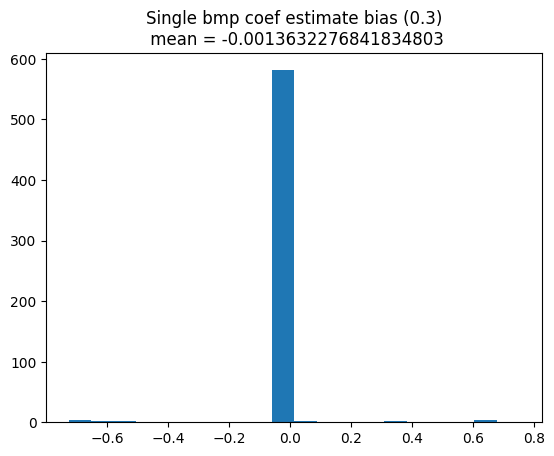

In [7]:
plt.hist(fit_coef_single_bias, bins=20)
fit_coef_single_bias_mean = np.mean(fit_coef_single_bias)
plt.title(f"Single bmp coef estimate bias (0.3)\n mean = {fit_coef_single_bias_mean}")
plt.show()

Variance of single mp (0.3)

In [31]:
fit_coef_single_mat.shape
fit_coef_single_var.shape

(600,)

In [8]:
fit_coef_single_var = np.var(fit_coef_single_mat, axis=1)

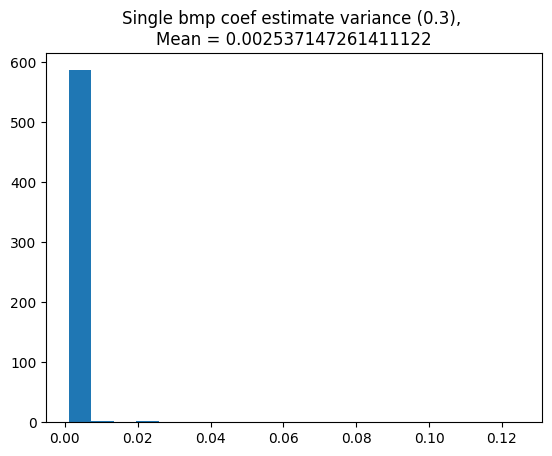

In [9]:
plt.hist(fit_coef_single_var, bins=20)
fit_coef_single_var_mean = np.mean(fit_coef_single_var)
plt.title("Single bmp coef estimate variance (0.3), \nMean = " + str(fit_coef_single_var_mean))
plt.show()

Do the same for 0.9, 0.9

-0.18874517908869565


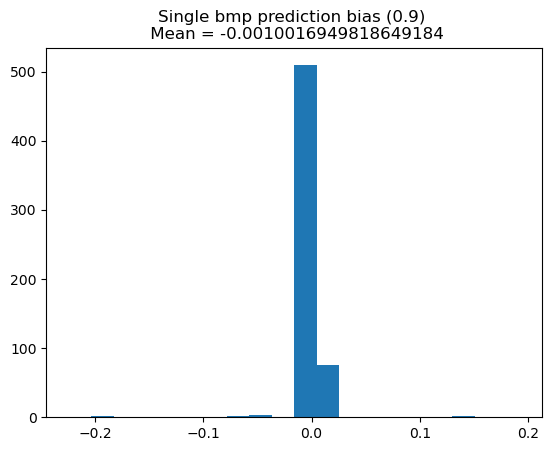

In [26]:
test_num = 500
N_bag = 1

model_params_single = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_single['random_seed'] = data_seed + i
    bmp_model_single = BMP(**model_params_single)
    bmp_model_single.fit(train_dictionary, train_perturbed_signal)
    coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
    fit_coef_lst.append(coef_tmp)
    
true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients
    
fit_coef_single_mat_09 = np.concatenate(fit_coef_lst, axis = 1)
fit_coef_single_mean_09 = np.mean(fit_coef_single_mat_09, axis=1)
fit_coef_single_bias_09 = fit_coef_single_mean_09.ravel() - true_coef_vec.ravel()

plt.hist(fit_coef_single_bias_09, bins=20)
fit_coef_single_bias_09_19 = fit_coef_single_bias_09[19]
print(fit_coef_single_bias_09_19)

fit_coef_single_bias_09_mean = np.mean(fit_coef_single_bias_09)

plt.title(f"Single bmp prediction bias (0.9) \n Mean = {fit_coef_single_bias_09_mean}")
plt.show()

0.09146760467237226


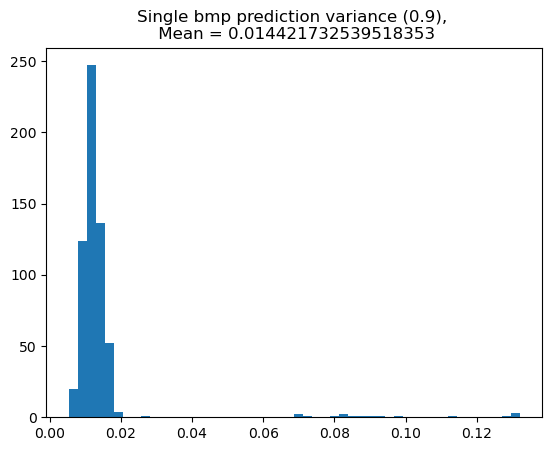

In [38]:
fit_coef_single_var_09 = np.var(fit_coef_single_mat_09, axis=1)

fit_coef_single_var_09_19 = fit_coef_single_var_09[19]
print(fit_coef_single_var_09_19)

plt.hist(fit_coef_single_var_09, bins=50)
fit_coef_single_var_09_mean = np.mean(fit_coef_single_var_09)
plt.title("Single bmp prediction variance (0.9), \n Mean = " + str(fit_coef_single_var_09_mean))
plt.show()

----------------------

## MSE

In [39]:
test_num = 500
N_bag = 100

model_params_ensemble = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_ensemble_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_ensemble['random_seed'] = data_seed + i
    bmp_model_ensemble = BMP(**model_params_ensemble)
    bmp_model_ensemble.fit(train_dictionary, train_perturbed_signal)
    fit_coef_tmp = bmp_model_ensemble.coefficients.reshape(-1, 1)
    fit_coef_ensemble_lst.append(fit_coef_tmp)
    
fit_coef_ensemble_mat = np.concatenate(fit_coef_ensemble_lst, axis = 1)

true_coef_vec = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec[true_indices] = true_coefficients

In [40]:
fit_coef_ensemble_mat.shape

(600, 500)

In [41]:
ensemble_coef_bias_multitrial = fit_coef_ensemble_mat - true_coef_vec
ensemble_coef_sq_bias_multitrial = ensemble_coef_bias_multitrial ** 2
ensemble_coef_sq_bias_multitrial.shape

(600, 500)

In [42]:
ensemble_coef_sq_bias_multitrial_exp = np.mean(ensemble_coef_sq_bias_multitrial, axis = 1)
ensemble_coef_sq_bias_multitrial_exp.shape

(600,)

0.20626372884725006


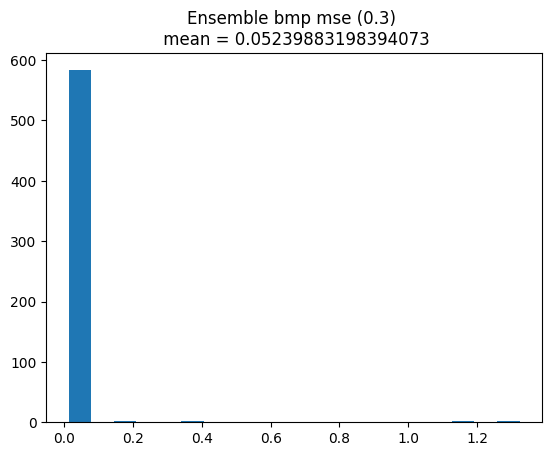

In [43]:
plt.hist(ensemble_coef_sq_bias_multitrial_exp, bins = 20)
ensemble_coef_sq_bias_multitrial_exp_19 = ensemble_coef_sq_bias_multitrial_exp[19]
print(ensemble_coef_sq_bias_multitrial_exp_19)
ensemble_coef_sq_bias_multitrial_exp_mean = np.mean(ensemble_coef_sq_bias_multitrial_exp)
plt.title('Ensemble bmp mse (0.3) \n mean = ' + str(ensemble_coef_sq_bias_multitrial_exp_mean))
plt.show()

In [37]:
ensemble_coef_sq_bias_multitrial_exp_mean / fit_coef_single_var_mean

0.28718459894583426

In [37]:
ensemble_coef_sq_bias_multitrial_exp_19 / fit_coef_single_var_19

1.3396096662440657

Do the same for 0.9, 0.9

In [36]:
test_num = 500
N_bag = 100

model_params_ensemble = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_ensemble_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_ensemble['random_seed'] = data_seed + i
    bmp_model_ensemble = BMP(**model_params_ensemble)
    bmp_model_ensemble.fit(train_dictionary, train_perturbed_signal)
    fit_coef_tmp = bmp_model_ensemble.coefficients.reshape(-1, 1)
    fit_coef_ensemble_lst.append(fit_coef_tmp)
    
fit_coef_ensemble_mat_09 = np.concatenate(fit_coef_ensemble_lst, axis = 1)

true_coef_vec_09 = np.zeros((test_dictionary.shape[1], 1))
true_coef_vec_09[true_indices] = true_coefficients

0.1026348714694503


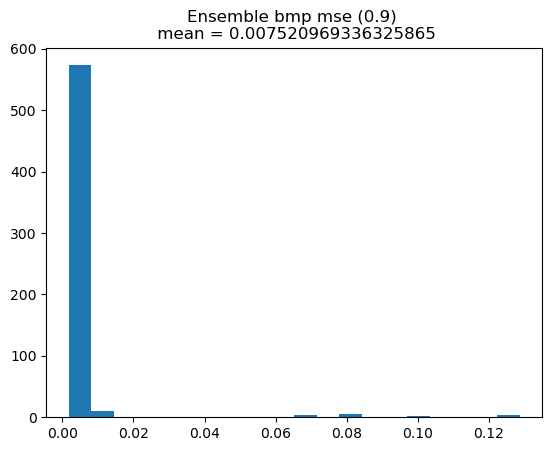

In [40]:
ensemble_coef_bias_multitrial_09 = fit_coef_ensemble_mat_09 - true_coef_vec_09
ensemble_coef_sq_bias_multitrial_09 = ensemble_coef_bias_multitrial_09 ** 2
ensemble_coef_sq_bias_multitrial_exp_09 = np.mean(ensemble_coef_sq_bias_multitrial_09, axis = 1)

plt.hist(ensemble_coef_sq_bias_multitrial_exp_09, bins = 20)

ensemble_coef_sq_bias_multitrial_exp_09_19 = ensemble_coef_sq_bias_multitrial_exp_09[19]
print(ensemble_coef_sq_bias_multitrial_exp_09_19)

ensemble_coef_sq_bias_multitrial_exp_mean_09 = np.mean(ensemble_coef_sq_bias_multitrial_exp_09)
plt.title('Ensemble bmp mse (0.9) \n mean = ' + str(ensemble_coef_sq_bias_multitrial_exp_mean_09))
plt.show()

In [41]:
ensemble_coef_sq_bias_multitrial_exp_mean_09 / fit_coef_single_var_09_mean

0.5215024835412074

In [42]:
ensemble_coef_sq_bias_multitrial_exp_09_19 / fit_coef_single_var_09_19

1.1220898572459403

--------------

## Correlation

In [43]:
test_num = 500
N_bag = 100

model_params_single = {
    'N_bag': 1,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_bag_multitiral_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    fit_coef_bag = []
    for j in range(N_bag):
        model_params_single['random_seed'] = data_seed + j
        bmp_model_single = BMP(**model_params_single)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        fit_coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
        fit_coef_bag.append(fit_coef_tmp)
    fit_coef_bag_multitiral_lst.append(fit_coef_bag)

In [44]:
len(fit_coef_bag_multitiral_lst[0][0])

600

In [45]:
stack_lst = []
for i in range(len(fit_coef_bag_multitiral_lst)):
    tmp = np.concatenate(fit_coef_bag_multitiral_lst[i], axis=1)
    stack_lst.append(tmp)

d3 = np.stack(stack_lst)
d3.shape

(500, 600, 100)

In [46]:
slice_Nbag_testnum = d3[:, 1, :]
slice_Nbag_testnum.shape

(500, 100)

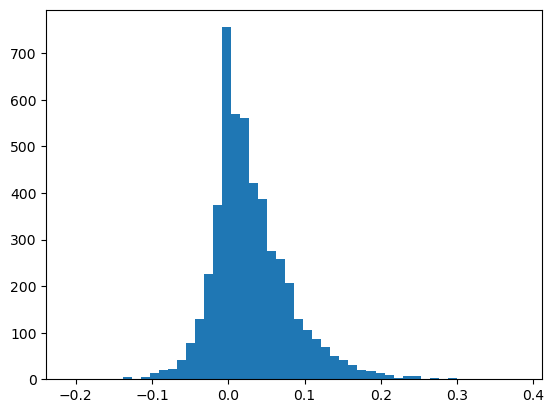

In [47]:
corr = np.corrcoef(slice_Nbag_testnum, rowvar=False)
corr.shape
upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
plt.hist(upper_corr, bins=50)
plt.show()

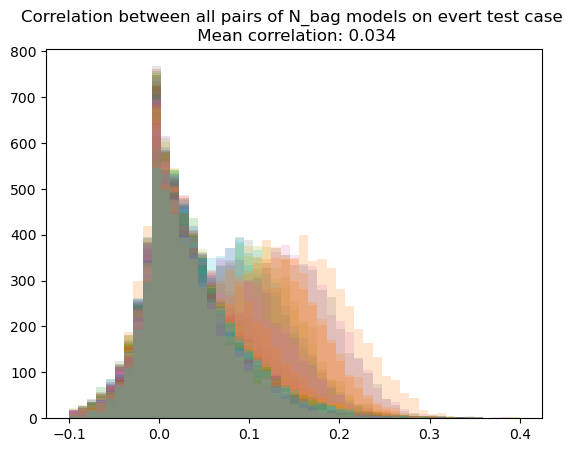

In [48]:
bins = np.linspace(-0.1, 0.4, 50)
all_corr = []

for i in range(d3.shape[1]):
    slice_tmp = d3[:, i, :]
    corr = np.corrcoef(slice_tmp, rowvar=False)
    upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
    all_corr.extend(upper_corr)
    plt.hist(upper_corr, bins=bins, alpha=0.2, label='test case {}'.format(i))
mean_corr = np.mean(all_corr)
plt.title('Correlation between all pairs of N_bag models on evert test case \n Mean correlation: {:.3f}'.format(mean_corr))
plt.show()


Check the corraltion for 0.9, 0.9

In [49]:
test_num = 500
N_bag = 100

model_params_single = {
    'N_bag': 1,
    'K': 50,
    'signal_bag_percent': 0.9,
    'atom_bag_percent': 0.9,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 600
n = 300
m = 20
noise_level = 0.2
data_seed = 2

fit_coef_bag_multitiral_lst_09 = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    fit_coef_bag = []
    for j in range(N_bag):
        model_params_single['random_seed'] = data_seed + j
        bmp_model_single = BMP(**model_params_single)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        fit_coef_tmp = bmp_model_single.coefficients.reshape(-1, 1)
        fit_coef_bag.append(fit_coef_tmp)
    fit_coef_bag_multitiral_lst_09.append(fit_coef_bag)
    
stack_lst_09 = []
for i in range(len(fit_coef_bag_multitiral_lst_09)):
    tmp = np.concatenate(fit_coef_bag_multitiral_lst_09[i], axis=1)
    stack_lst_09.append(tmp)

d3_09 = np.stack(stack_lst_09)
d3_09.shape

(500, 600, 100)

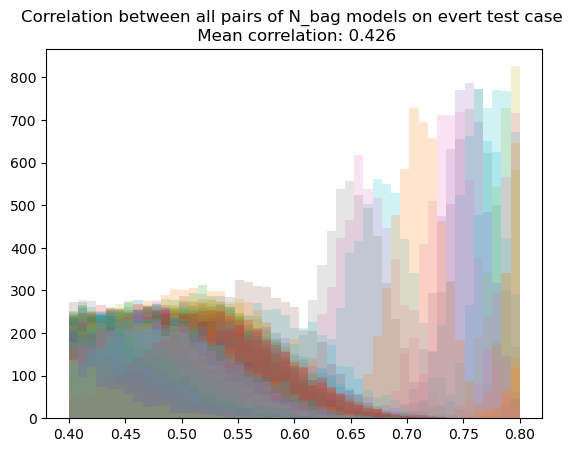

In [50]:
bins = np.linspace(0.4, 0.8, 50)
all_corr = []

for i in range(d3_09.shape[1]):
    slice_tmp = d3_09[:, i, :]
    corr = np.corrcoef(slice_tmp, rowvar=False)
    upper_corr = corr[np.triu_indices(corr.shape[0], k=1)]
    all_corr.extend(upper_corr)
    plt.hist(upper_corr, bins=bins, alpha=0.2, label='test case {}'.format(i))
mean_corr = np.mean(all_corr)
plt.title('Correlation between all pairs of N_bag models on evert test case \n Mean correlation: {:.3f}'.format(mean_corr))
plt.show()

-----------------------

All below are not related

In [ ]:
test_num = 500
N_bag = 1

model_params_single = {
    'N_bag': N_bag,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 300
n = 600
m = 20
noise_level = 0.2
data_seed = 2

y_pred_lst = []

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()

for i in range(test_num):
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + i)
    model_params_single['random_seed'] = data_seed + i
    bmp_model_single = BMP(**model_params_single)
    bmp_model_single.fit(train_dictionary, train_perturbed_signal)
    y_pred_single = bmp_model_single.predict(test_dictionary)
    y_pred_lst.append(y_pred_single)
    
y_pred_single_mat = np.concatenate(y_pred_lst, axis = 1)

In [144]:
test_num = 50

# variance because of bagging

def cal_bagging_variance(n, p, m, data_seed, noise_level, model_params, test_num):
    Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
    test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()
    coef = np.zeros((test_dictionary.shape[1], 1))
    coef[true_indices] = true_coefficients
    coef = coef.ravel()
    _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed =  data_seed + 100)
    y_pred_lst = []
    y_pred_re_lst = []
    coef_lst = []
    coef_re_lst = []
    for test_i in range(test_num):
        _, train_dictionary_resample, _, _, train_perturbed_signal_resample = Data_Geneartor.keep_coef_reshuffle(seed = data_seed + test_i)
        model_params['random_seed'] = data_seed + test_i
        bmp_model_single = BMP(**model_params)
        bmp_model_single.fit(train_dictionary, train_perturbed_signal)
        coef_lst.append(bmp_model_single.coefficients.reshape(-1, 1))
        bmp_model2 = BMP(**model_params)
        bmp_model2.fit(train_dictionary_resample, train_perturbed_signal_resample)
        coef_re_lst.append(bmp_model2.coefficients.reshape(-1, 1))
        y_pred_re = bmp_model2.predict(test_dictionary)
        y_pred_re_lst.append(y_pred_re)
        y_pred = bmp_model_single.predict(test_dictionary)
        y_pred_lst.append(y_pred)
    y_pred_mat = np.concatenate(y_pred_lst, axis = 1)
    y_pred_re_mat = np.concatenate(y_pred_re_lst, axis = 1)
    coef_mat = np.concatenate(coef_lst, axis = 1)
    coef_re_mat = np.concatenate(coef_re_lst, axis = 1)
    
    return y_pred_mat, y_pred_re_mat, test_true_signal, test_perturbed_signal, coef_mat, coef_re_mat, coef, true_indices

In [166]:
model_params = {
    'N_bag': 1,
    'K': 50,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 300
n = 600
m = 20
noise_level = 0.2
data_seed = 2

y_pred_mat, y_pred_re_mat, test_true_signal, test_perturbed_signal, coef_mat, coef_re_mat, coef, true_indices = cal_bagging_variance(n, p, m, data_seed, noise_level, model_params, 1000)

In [167]:
y_pred_mat.shape

(600, 1000)

In [168]:
en_pred = np.mean(y_pred_mat, axis=1).reshape(-1, 1)

In [169]:
test_true_signal.shape

(600, 1)

In [170]:
mse = np.mean((test_true_signal - en_pred)**2)
mse

0.004568843089159411

In [171]:
test_err = np.mean((test_perturbed_signal - en_pred)**2)
test_err

0.044543106404829225

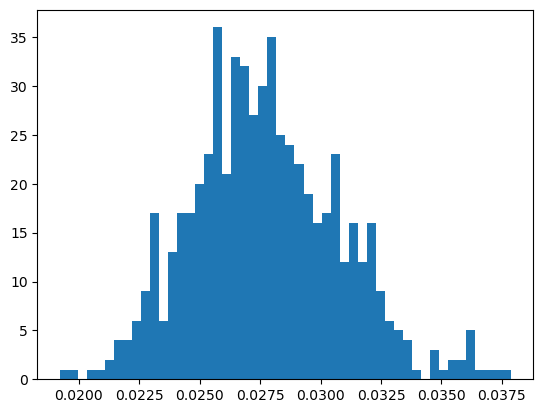

In [172]:
pred_var = np.var(y_pred_mat, axis=1)
plt.hist(pred_var, bins=50)
plt.show()

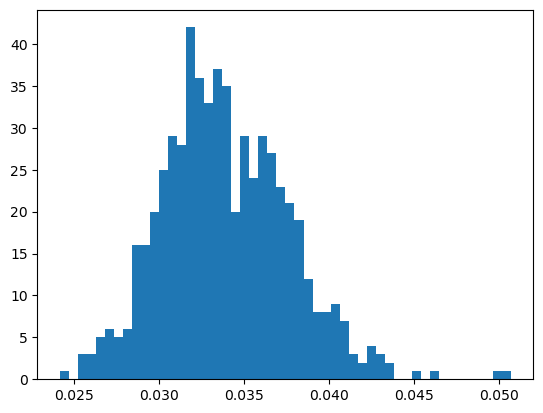

In [174]:
pred_re_var = np.var(y_pred_re_mat, axis=1)
plt.hist(pred_re_var, bins=50)
plt.show()

In [175]:
np.mean(pred_var)

0.02774428124886441

In [176]:
pred_corr = np.corrcoef(y_pred_mat, rowvar=False)
pred_corr_utri = pred_corr[np.triu_indices(pred_corr.shape[0], k=1)]
np.mean(pred_corr_utri)

0.37417507897739277

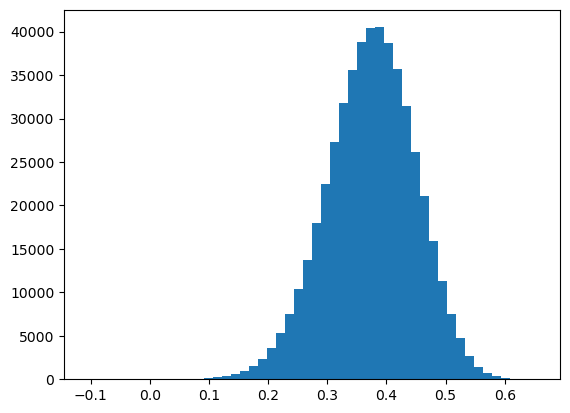

In [177]:
plt.hist(pred_corr_utri, bins = 50)
plt.show()

In [178]:
np.mean(pred_re_var)

0.03393223925904527

In [179]:
pred_corr = np.corrcoef(y_pred_re_mat, rowvar=False)
pred_corr_utri = pred_corr[np.triu_indices(pred_corr.shape[0], k=1)]
np.mean(pred_corr_utri)

0.2573670606428

In [180]:
mse / np.mean(pred_var)

0.16467693101065348

coef

In [181]:
coef_mat.shape

(300, 1000)

In [182]:
true_indice_coef = coef_mat[true_indices, :]

In [183]:
coef_avg = np.mean(coef_mat, axis=1)
coef_avg.shape

(300,)

In [184]:
coef_var = np.var(coef_mat, axis=1)
np.mean(coef_var)

0.055691895953478315

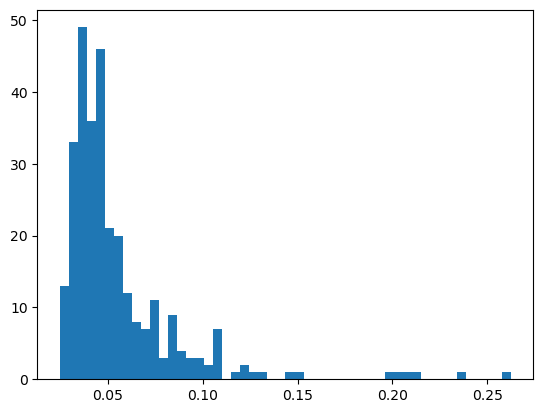

In [185]:
plt.hist(coef_var, bins=50)
plt.show()

(array([2., 3., 0., 1., 0., 1., 2., 4., 0., 1., 0., 0., 0., 0., 2., 2., 0.,
        1., 0., 1.]),
 array([0.04130872, 0.05236231, 0.06341591, 0.07446951, 0.08552311,
        0.0965767 , 0.1076303 , 0.1186839 , 0.1297375 , 0.14079109,
        0.15184469, 0.16289829, 0.17395189, 0.18500548, 0.19605908,
        0.20711268, 0.21816628, 0.22921987, 0.24027347, 0.25132707,
        0.26238067]),
 <BarContainer object of 20 artists>)

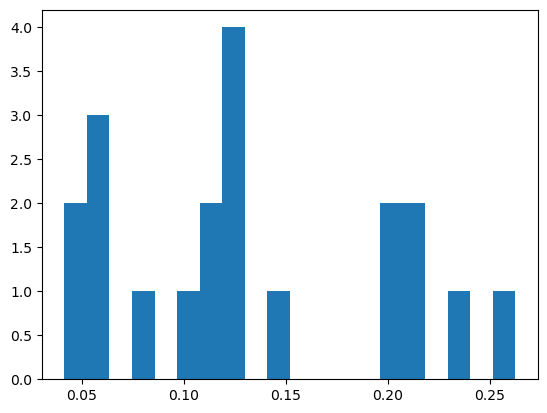

In [198]:
true_coef_var = np.mean(coef_var[true_indices])
true_coef_var
plt.hist(coef_var[true_indices], bins=20)

In [190]:
true_coef_mse = np.mean((coef_avg[true_indices] - coef[true_indices])**2)
true_coef_mse

0.05786680788949945

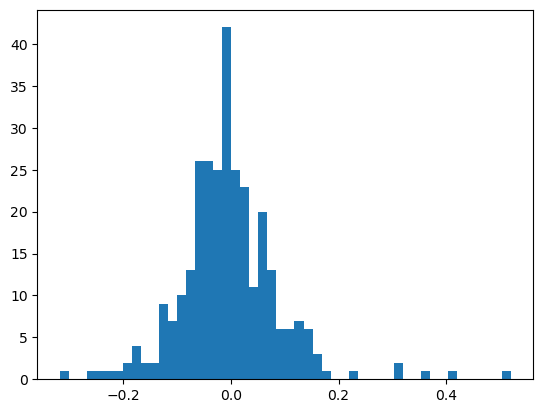

In [191]:
plt.hist(coef_avg - coef, bins = 50)
plt.show()

In [194]:
true_coef_corr = np.corrcoef(coef_mat[true_indices, :], rowvar=False)
true_coef_corr_utri = true_coef_corr[np.triu_indices(true_coef_corr.shape[0], k=1)]
np.mean(true_coef_corr_utri)

0.7690556470919081

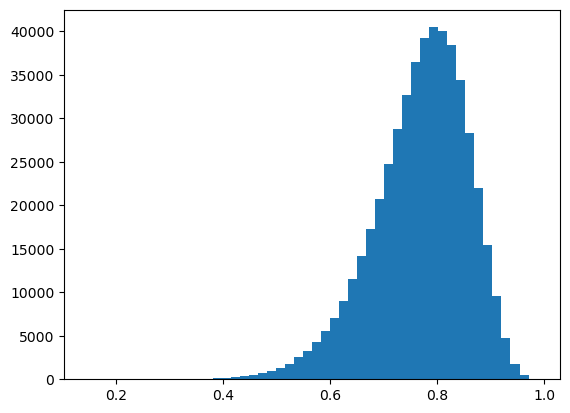

In [197]:
plt.hist(true_coef_corr_utri,  bins=50)
plt.show()

In [195]:
true_coef_mse / true_coef_var

0.438342836166106

In [193]:
coef_mat.shape

(300, 1000)

In [142]:
coef_mat.shape

(300, 500)

In [136]:
coef_corr = np.corrcoef(coef_mat, rowvar=False)
coef_corr_utri = coef_corr[np.triu_indices(coef_corr.shape[0], k=1)]
np.mean(coef_corr_utri)

0.361988966453134

In [143]:
coef_corr.shape

(500, 500)

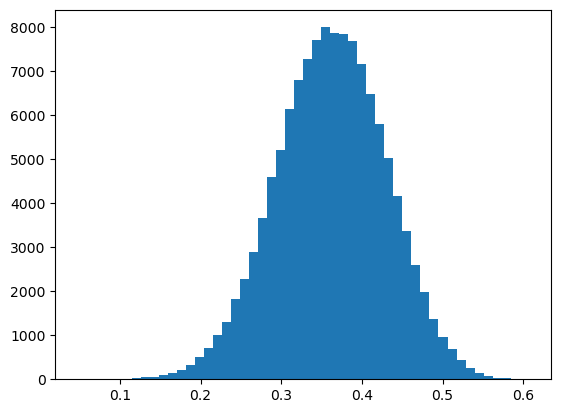

In [140]:
plt.hist(coef_corr_utri, bins = 50)
plt.show()

In [163]:
coef_mse / np.mean(coef_var)

0.15718096309857135